In [1]:
!pip install -q "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install -q --no-deps xformers trl peft accelerate bitsandbytes datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import os
import re
import json
from dataclasses import dataclass
from typing import List

from dotenv import load_dotenv
from huggingface_hub import login

from pricer.items import Item
from pricer.evaluator import evaluate

import torch
from datasets import Dataset
from unsloth import FastLanguageModel
from trl import SFTTrainer
from transformers import TrainingArguments
from google.colab import userdata


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [3]:
# environment

LITE_MODE = False

load_dotenv(override=True)
hf_token = userdata.get('HF_TOKEN')
login(hf_token)

username = "ed-donner"
dataset = f"{username}/items_lite" if LITE_MODE else f"{username}/items_full"

train, val, test = Item.from_hub(dataset)

print(f"Loaded {len(train):,} training items, {len(val):,} validation items, {len(test):,} test items")

Loaded 800,000 training items, 10,000 validation items, 10,000 test items


In [4]:
# Same slicing strategy as your OpenAI notebook
fine_tune_train = train[:100]
fine_tune_validation = val[:50]

len(fine_tune_train), len(fine_tune_validation)


(100, 50)

In [5]:
def messages_for(item: Item):
    message = (
        "Estimate the price of this product. Respond with the price, no explanation\n\n"
        f"{item.summary}"
    )
    return [
        {"role": "user", "content": message},
        {"role": "assistant", "content": f"${item.price:.2f}"},
    ]

def test_messages_for(item: Item):
    message = (
        "Estimate the price of this product. Respond with the price, no explanation\n\n"
        f"{item.summary}"
    )
    return [
        {"role": "user", "content": message},
    ]

messages_for(fine_tune_train[0])


[{'role': 'user',
  'content': 'Estimate the price of this product. Respond with the price, no explanation\n\nTitle: Schlage F59 & 613 Andover Interior Knob (Deadbolt Included)  \nCategory: Home Hardware  \nBrand: Schlage  \nDescription: A single‑piece oil‑rubbed bronze knob that mounts to a deadbolt for secure, easy interior door use.  \nDetails: Designed for a 4" minimum center‑to‑center door prep, it offers a lifetime mechanical and finish warranty and comes ready for quick installation.'},
 {'role': 'assistant', 'content': '$64.30'}]

In [6]:
BASE_MODEL = "unsloth/gemma-3-4b-it-unsloth-bnb-4bit"
MAX_SEQ_LENGTH = 2048

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = BASE_MODEL,
    max_seq_length = MAX_SEQ_LENGTH,
    load_in_4bit = True,
)

model = FastLanguageModel.get_peft_model(
    model,
    r = 16,
    lora_alpha = 16,
    lora_dropout = 0.0,
    target_modules = "all-linear",
)

print("Model & LoRA adapter ready.")


Using device: cuda
==((====))==  Unsloth 2025.12.6: Fast Gemma3 patching. Transformers: 4.57.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Using float16 precision for gemma3 won't work! Using float32.
Unsloth: Gemma3 does not support SDPA - switching to fast eager.
Unsloth: Making `base_model.model.model.vision_tower.vision_model` require gradients
Model & LoRA adapter ready.


In [7]:
from datasets import Dataset

train_rows = [{"messages": messages_for(item)} for item in fine_tune_train]
val_rows   = [{"messages": messages_for(item)} for item in fine_tune_validation]

train_ds: Dataset = Dataset.from_list(train_rows)
val_ds: Dataset   = Dataset.from_list(val_rows)

train_ds[0]


{'messages': [{'content': 'Estimate the price of this product. Respond with the price, no explanation\n\nTitle: Schlage F59 & 613 Andover Interior Knob (Deadbolt Included)  \nCategory: Home Hardware  \nBrand: Schlage  \nDescription: A single‑piece oil‑rubbed bronze knob that mounts to a deadbolt for secure, easy interior door use.  \nDetails: Designed for a 4" minimum center‑to‑center door prep, it offers a lifetime mechanical and finish warranty and comes ready for quick installation.',
   'role': 'user'},
  {'content': '$64.30', 'role': 'assistant'}]}

In [8]:
def to_text(example):
    text = tokenizer.apply_chat_template(
        example["messages"],
        tokenize = False,
        add_generation_prompt = False,
    )
    return {"text": text}

train_ds = train_ds.map(to_text)
val_ds   = val_ds.map(to_text)

train_ds[0]["text"][:400]


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

'<bos><start_of_turn>user\nEstimate the price of this product. Respond with the price, no explanation\n\nTitle: Schlage F59 & 613 Andover Interior Knob (Deadbolt Included)  \nCategory: Home Hardware  \nBrand: Schlage  \nDescription: A single‑piece oil‑rubbed bronze knob that mounts to a deadbolt for secure, easy interior door use.  \nDetails: Designed for a 4" minimum center‑to‑center door prep, it offers'

In [15]:
BATCH_SIZE = 2
GRAD_ACCUM = 4
EPOCHS = 5
LR = 2e-4
LOG_STEPS = 10
OUTPUT_DIR = "price_lora"

training_args = TrainingArguments(
    output_dir = OUTPUT_DIR,
    per_device_train_batch_size = BATCH_SIZE,
    gradient_accumulation_steps = GRAD_ACCUM,
    learning_rate = LR,
    num_train_epochs = EPOCHS,
    logging_steps = LOG_STEPS,
    bf16 = False,          # <- change this
    fp16 = True,           # <- OK on T4
    save_strategy = "epoch",
    report_to = "none",
)


trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_ds,
    eval_dataset = val_ds,
    dataset_text_field = "text",
    max_seq_length = MAX_SEQ_LENGTH,
    packing = True,
    args = training_args,
)

print("Trainer ready.")


Unsloth: Switching to float32 training since model cannot work with float16


Unsloth: Tokenizing ["text"] (num_proc=6):   0%|          | 0/100 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"] (num_proc=6):   0%|          | 0/50 [00:00<?, ? examples/s]

Trainer ready.


In [16]:
train_result = trainer.train()
train_result


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 100 | Num Epochs = 5 | Total steps = 65
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 38,497,792 of 4,338,577,264 (0.89% trained)


Step,Training Loss
10,1.812200
20,1.485500
30,1.239600
40,1.108400
50,0.930000
60,0.829500


TrainOutput(global_step=65, training_loss=1.1976056942572961, metrics={'train_runtime': 257.9221, 'train_samples_per_second': 1.939, 'train_steps_per_second': 0.252, 'total_flos': 1503089629922496.0, 'train_loss': 1.1976056942572961, 'epoch': 5.0})

In [11]:
model.save_pretrained(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)

print(f"Saved LoRA adapter and tokenizer to: {OUTPUT_DIR}")


Saved LoRA adapter and tokenizer to: price_lora


In [17]:
FastLanguageModel.for_inference(model)

def price_model(item):
    messages = [
        {
            "role": "user",
            "content": (
                "Estimate the price of this product. Respond with the price, no explanation\n\n"
                f"{item.summary}"
            ),
        }
    ]
    prompt = tokenizer.apply_chat_template(
        messages,
        tokenize = False,
        add_generation_prompt = True,
    )

    # IMPORTANT: call tokenizer, not processor, and pass text via `text=`
    inputs = tokenizer(
        text=[prompt],
        return_tensors="pt",
    ).to(device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens = 7,
        )

    text_out = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return text_out.strip()


  0%|          | 0/200 [00:00<?, ?it/s]

$217 $1899 $44 $60 $49 $218 $507 $124 $279780 $309 $1289 $343 $26 $48 $73 $23 $69 $68 $204 $54 $166 $92 $72 $172 $2695 $433 $492 $10 $32 $920 $10 $40 $109 $76 $112 $812 $660 $55 $198 $82 $198 $65 $15 $251 $170 $21306 $134 $14 $129 $1812 $9 $127 $473 $105 $7447 $133 $61 $319 $1813 $55 $181 $58 $89 $108 $619 $73 $1772 $398 $1893 $72 $22 $83 $30 $1971 $40 $16 $266 $5 $5 $5981 $30 $8 $26 $93 $19 $56 $111025 $299 $110 $38 $5 $93 $8 $23 $26 $226 $19 $1154 $269 $15903 $96 $113 $34 $77 $245 $9182 $22 $310 $28 $2712 $46 $21 $19 $40 $194 $340 $24 $17 $52 $100 $44 $311 $66 $82 $188 $53 $3580 $85 $161 $361 $516 $1870 $64 $1991 $64 $12 $7897 $65 $2890 $111 $47 $235 $2356 $17 $190 $2068 $31 $1490 $260 $167 $7 $97 $46 $128 $81 $1731 $1963 $48 $285 $48 $713 $494 $35 $1 $827 $1977 $358 $310 $39 $890 $1986 $48 $404 $20 $5228 $143 $9 $4 $90 $20 $630 $229 $1800 $1750 $46 $19 $118 $57 $30 $9 $18 $47 $29 $124 $84 $53 $160 $210 $48 $23 
Price Model results Error: $2,674.22  MSE: 458,423,996  r²: -2085774.9%


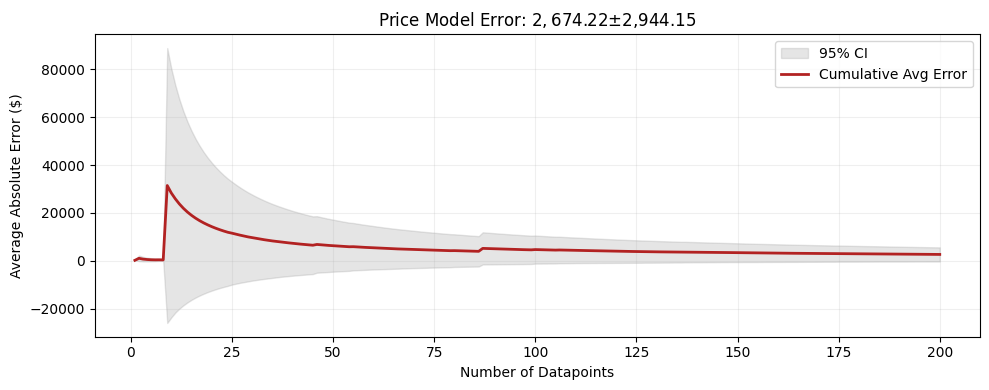

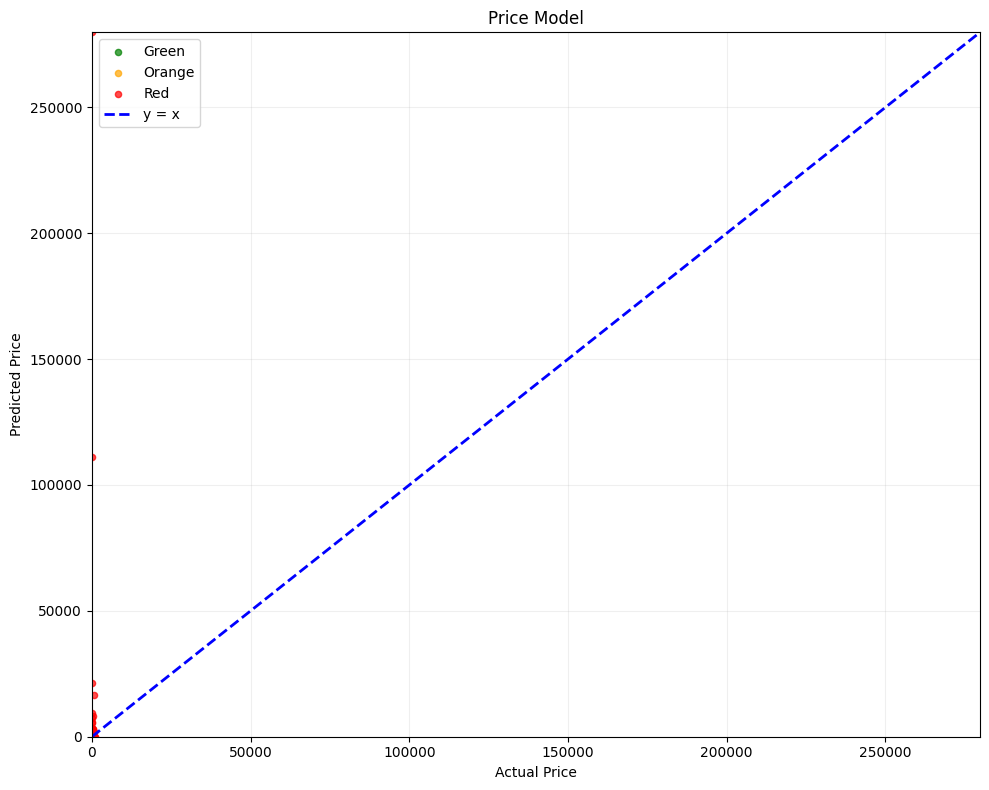

In [18]:
# Evaluate on the test set with your existing visualization & metrics
evaluate(price_model, test, workers=1)
